# Generate frequent sequences of countries


### Import required libraries

In [1]:
import pandas as pd
import os
import numpy as np

from tqdm.notebook import tqdm
import json
import networkx as nx

import matplotlib.pyplot as plt

import math

import itertools

### Load datasets

In [2]:
source= 'lfm' # 'lfm' or 'spotify'

ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2022_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])

if source== 'lfm':
    ranking_df= pd.read_csv(os.path.join('data', 'LMF-2b', 'clean_ranking_2005_2020_lfm.csv'), index_col=0, parse_dates=['Date', 'release_date'])
    
ranking_df.head()

/home/fterroso/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,song_id,Date,Streams,Region,release_date,day_of_study,Position
18,991,2016-12-22,11,Belarus,2016-12-22,4325,1.0
19,991,2017-01-23,22,Belarus,2016-12-22,4357,4.0
20,991,2017-01-24,27,Belarus,2016-12-22,4358,13.0
21,991,2016-12-29,11,Russia,2016-12-22,4332,1.0
86,4774,2012-08-22,11,Brazil,2012-06-13,2742,1.0


In [3]:
ranking_df['week_of_study']= ranking_df['day_of_study'].apply(lambda x : int(x/7))

In [4]:
ranking_df = ranking_df[ranking_df['Region']!='World']

In [5]:
ranking_df['Region'].unique()

array(['Belarus', 'Russia', 'Brazil', 'Germany', 'Finland', 'Norway',
       'USA', 'Turkey', 'Ukraine', 'Australia', 'Sweden', 'Poland',
       'Belgium', 'Bulgaria', 'Chile', 'Egypt', 'Italy', 'Japan',
       'Kazakhstan', 'Lithuania', 'Latvia', 'Netherlands', 'Romania',
       'Slovakia', 'Canada', 'Indonesia', 'Marocco', 'Spain',
       'Switzerland', 'HongKong', 'France', 'Iceland', 'Estonia',
       'NewZealand', 'CzechRepublic', 'Denmark', 'Argentina', 'Hungary',
       'Austria', 'Malaysia', 'Portugal', 'Columbia', 'Greece', 'Mexico',
       'Vietnam', 'Ecuador', 'Philippines', 'Ireland', 'Uruguay', 'Peru',
       'CostaRica', 'Singapore', 'India', 'Guatemala', 'ElSalvador',
       'SouthAfrica', 'Luxemborg', 'SaudiArabia', 'Korea', 'Bolivia',
       'Honduras', 'Paraguay', 'Israel', 'Nicaragua', 'DominicanRepublic',
       'UnitedArabEmirates', 'Panama'], dtype=object)

In [6]:
ranking_df[ranking_df['song_id']=='4nK5YrxbMGZstTLbvj6Gxw']

,song_id,Date,Streams,Region,release_date,day_of_study,Position,week_of_study


In [7]:
ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522605 entries, 18 to 3020060
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   song_id        1522605 non-null  int64         
 1   Date           1522605 non-null  datetime64[ns]
 2   Streams        1522605 non-null  int64         
 3   Region         1522605 non-null  object        
 4   release_date   1522605 non-null  datetime64[ns]
 5   day_of_study   1522605 non-null  int64         
 6   Position       1522605 non-null  float64       
 7   week_of_study  1522605 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 104.5+ MB


In [8]:
total_songs = ranking_df['song_id'].nunique()
print(f'The number of total songs is {total_songs}')

The number of total songs is 171493


### Read songs genres

In [9]:
song_genres_df = pd.read_csv(os.path.join('data', 'songs_genres_2017_2022.csv'), index_col=0)
song_genres_df.head()

,0,1,2,3,4,5,6
6m2LNopVJKsvBB9l7Z1rwn,funk,pop,NaN,NaN,NaN,NaN,NaN
7Ckhk1XW5NV2k4jpqtQNlz,reggaeton,latin,NaN,NaN,NaN,NaN,NaN
7MHN1aCFtLXjownGhvEQlF,reggaeton,latin,NaN,NaN,NaN,NaN,NaN
1xndOD8CreR5ctkOv5G1LN,hardcore,NaN,NaN,NaN,NaN,NaN,NaN
3xWEI23MLJrD0dpDcDUTW6,reggaeton,latin,pop,NaN,NaN,NaN,NaN


### Read songs genre groups

In [10]:
import json

# Opening JSON file
f = open(os.path.join('data','music_styles_unique.json'))
 
# returns JSON object as
# a dictionary
music_styles = json.load(f)

sub_gender_to_gender = {}
for gender, sub_genders in music_styles.items():
    for sb in sub_genders:
        sub_gender_to_gender[sb]=gender
sub_gender_to_gender

{'pop rock': 'pop',
 'pop': 'pop',
 'british': 'pop',
 'j-pop': 'pop',
 'k-pop': 'pop',
 'mandopop': 'pop',
 'cantopop': 'pop',
 'hip-hop': 'hip-hop',
 'funk': 'hip-hop',
 'trap': 'hip-hop',
 'rap': 'hip-hop',
 'rock': 'rock',
 'rockabilly': 'rock',
 'metal': 'rock',
 'punk': 'rock',
 'metalcore': 'rock',
 'hardcore': 'rock',
 'j-rock': 'rock',
 'grunge': 'rock',
 'trance': 'electronic',
 'chill': 'electronic',
 'dance': 'electronic',
 'edm': 'electronic',
 'house': 'electronic',
 'dubstep': 'electronic',
 'dancehall': 'electronic',
 'electro': 'electronic',
 'techno': 'electronic',
 'electronic': 'electronic',
 'club': 'electronic',
 'latin': 'latin',
 'reggaeton': 'latin',
 'spanish': 'latin',
 'pagode': 'latin',
 'cumbia': 'latin',
 'salsa': 'latin',
 'latino': 'latin',
 'sertanejo': 'latin',
 'mpb': 'latin',
 'anime': 'indie',
 'indie': 'indie',
 'alternative': 'indie',
 'emo': 'indie',
 'soundtracks': 'classical and ost',
 'classical': 'classical and ost',
 'piano': 'classical and

### Auxiliary functions

In [11]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def compute_weight_fn(target_country, song_ranking_, init_day, d, week_diff, weight_coeff_):
    
    country_values = []
    weights = []  
    for d_curr in daterange(init_day, d+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region']==target_country) & 
                                    (song_ranking_['Date']==d_curr)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]

            diff_ = (d_curr-d).days
            weight = math.exp((diff_/weight_coeff_))

            value_ = weight * (float(rank_value)**-1)
            country_values.append(value_)
                
    link_value = ((float(week_diff)**-1) * sum(country_values))
        
    return link_value

def compute_ranking_weight_fn(target_country, song_ranking_, init_day, d):
    country_values = []
    rank_lst = []  
    for d_curr in daterange(init_day, d+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region']==target_country) & 
                                    (song_ranking_['Date']==d_curr)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]
            rank_lst.append(rank_value)
        #else:
        #    rank_lst.append(300)
    rank_series = pd.Series(rank_lst)
    return rank_series.ewm(alpha=0.1, adjust=False).mean().mean()

def get_paths_from_graph(G, cutoff_=100):
    
    roots = []
    leaves = []
    for node in G.nodes:
        if G.in_degree(node) == 0 : # it's a root
            roots.append(node)
        elif G.out_degree(node) == 0 : # it's a leaf
                leaves.append(node)
    
    paths = []
    for root in roots :
        for leaf in leaves :
            for path in nx.all_simple_paths(G, root, leaf, cutoff= cutoff_):
                paths.append(path)

    return paths

def update_graph(G, df, song_id):
    for i, v in df.iterrows():
        origin = v['source']
        dest = v['target']
        
        if G.has_edge(origin,dest):
            edge_songs = G[origin][dest]['songs']
            edge_songs.add(str(song_id))
            G[origin][dest]['songs'] = edge_songs
            G[origin][dest]['size']= len(edge_songs)
        else:
            songs_= set()
            songs_.add(song_id)
            G.add_edge(origin, dest, songs=songs_, size=1)
    
    return G


### Generate sequences from graph

We calculate the maximum value between two countries

In [12]:
def generate_graphs_fn(min_link_val, n_day_lags_):
    
    G_global= nx.empty_graph(1,create_using=nx.DiGraph())
    G_genres = {}
    songs_in_graph = set()
    songs_in_graph_genre = {}

    weight_coeff_= int(n_day_lags_/2)

    for s in tqdm(ranking_df['song_id'].unique()):

        country_at_prev_d = set()
        all_countries = set()
        prev_origins = set()
        prev_destinations = set()
        
        song_ranking= ranking_df[ranking_df['song_id']==s]
        dates=song_ranking.groupby('Region')['Date'].min().to_frame()
        dates_sort=dates.sort_values('Date')
        dates_sort= dates_sort.reset_index().set_index('Date')

        dates_lst=dates_sort.index.unique()

        src_lst = []
        target_lst = []
        weight_lst = []

        num_countries_at_d = -1

        for d in dates_lst:

            countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region'].unique())

            num_countries_at_d = len(countries_at_d)

            # We only use as origins countries that have not act as origin so far.
            o_countries = list((country_at_prev_d.intersection(countries_at_d))-prev_origins)
            d_countries = countries_at_d-country_at_prev_d-prev_destinations


            for oc in o_countries:
                init_week = song_ranking[song_ranking['Region']==oc]['week_of_study'].min()
                init_date = song_ranking[song_ranking['Region']==oc]['Date'].min()

                curr_week = song_ranking[(song_ranking['Region']==oc) & 
                                         (song_ranking['Date']==d)]['week_of_study'].values[0]

                week_diff = (curr_week-init_week)+1

                init_day = d - timedelta(n_day_lags_)

                days_diff = (d-init_date).days
                if  days_diff < n_day_lags_:
                    init_day = d - timedelta(days_diff)

                #link_value = compute_ranking_weight_fn(oc, song_ranking, init_day, d)
                link_value = compute_weight_fn(oc, song_ranking, init_day, d, week_diff, weight_coeff_)
                
                if link_value >= min_link_val:
                    for dc in d_countries:
                        if dc not in all_countries:
                            src_lst.append(oc)
                            target_lst.append(dc)
                            weight_lst.append(link_value)


            country_at_prev_d = countries_at_d
            all_countries = all_countries.union(countries_at_d)
            prev_origins = prev_origins.union(o_countries)
            prev_destinations =  prev_destinations.union(d_countries)
                
        graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst})

        if not graph_df.empty:
            songs_in_graph.add(s)
            G_global= update_graph(G_global, graph_df, s)

            if s in song_genres_df.index:
                genres_ = song_genres_df.loc[s].values
                for g in genres_:
                    if g in sub_gender_to_gender:
                        g_clus = sub_gender_to_gender[g]
                        G_ = G_genres.get(g_clus, nx.empty_graph(1,create_using=nx.DiGraph()))
                        G_= update_graph(G_, graph_df, s)
                        G_genres[g_clus]= G_
                        
                        song_set = songs_in_graph_genre.get(g_clus, set())
                        song_set.add(s)
                        songs_in_graph_genre[g_clus]= song_set
        
    return G_global, G_genres, songs_in_graph, songs_in_graph_genre

In [13]:
n_day_lags = 40
min_link_val = 0.01
G_global, G_genres, songs_in_graph, songs_in_graph_genre =generate_graphs_fn(min_link_val, n_day_lags)

  0%|          | 0/171493 [00:00<?, ?it/s]

In [14]:
def plot_graph(G, to_file=False, file_name=None):
    
    G.remove_nodes_from(list(nx.isolates(G)))

    pos = nx.spring_layout(G, k=20/math.sqrt(G.order()));
    plt.figure(3,figsize=(10,10)) 
    nx.draw_networkx_nodes(G, pos);
    nx.draw_networkx_edges(G, pos, width=2, arrowsize=30);#, alpha=0.3);
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='red', font_weight='bold')

    plt.axis("off")
    
    if to_file:
        plt.savefig(os.path.join('figs',f'07_MMP_{file_name}.png'), bbox_inches='tight')
    
    plt.show()


In [15]:
nx.write_gpickle(G_global,os.path.join('data', 'graphs', f'G_global_07_{source}.gpickle'))
nx.write_gpickle(G_genres,os.path.join('data', 'graphs', f'G_genres_07_{source}.gpickle'))

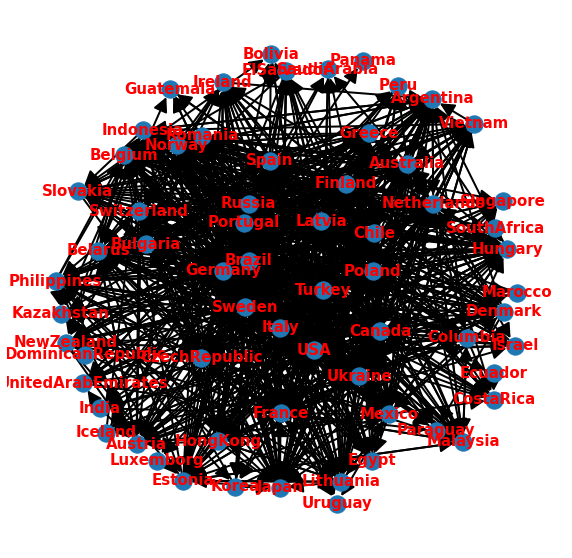

In [16]:
plot_graph(G_global)

## Extract patterns from graph

In [17]:
G_global = nx.read_gpickle(os.path.join('data', 'graphs', f'G_global_07_{source}.gpickle'))
G_genres = nx.read_gpickle(os.path.join('data', 'graphs', f'G_genres_07_{source}.gpickle'))

In [18]:
import sys
def merge_paths(G, paths):
    if len(paths) > 4:
        print(paths)
        print([c for c in nx.weakly_connected_components(G)])
        C = max(nx.strongly_connected_components(G), key=len)
        S = G.subgraph(C)
        nx.draw(S)
        print('-'*8)
        sys.exit()
    
def extract_patterns_from_graph(G, min_size, min_length):
    final_paths= {}
    visited_songs= set()

    edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['size'] < min_size]

    G.remove_edges_from(edges_to_remove)

    for u_target, v_target, data_target in tqdm(G.edges(data=True)):
        songs_to_visit = set()

        for i in range(min_size, len(data_target['songs'])):
            song_to_add = set()
            G_target = G.copy()
            edges_to_remove = []
            for u,v,d in G_target.edges(data=True):
                overlapped_songs= d['songs'].intersection(data_target['songs'])
                overlapped_songs_lngth= len(overlapped_songs)
                #print(overlapped_songs, overlapped_songs_lngth)
                if (overlapped_songs_lngth != i) or (overlapped_songs in visited_songs):
                    edges_to_remove.append((u,v))
                else:
                    songs_to_visit= songs_to_visit.union(overlapped_songs)
                    song_to_add= song_to_add.union(overlapped_songs)


            G_target.remove_edges_from(edges_to_remove)
            G_target.remove_nodes_from(list(nx.isolates(G_target)))

            paths= get_paths_from_graph(G_target) #[c for c in nx.weakly_connected_components(G_target)] #get_paths_from_graph(G_target)
            for p in paths:
                #G_p = G.subgraph(p)
                path_length = len(p) #G_p.number_of_nodes()#len(p)
                if path_length >= min_length:
                    #graph_hash = nx.weisfeiler_lehman_graph_hash(G_p)
                    #final_paths_hash[graph_hash]=G_p
                    paths_with_length = final_paths.get(path_length, {})     
                    t = paths_with_length.get(tuple(p),set())#paths_with_length.get(graph_hash,set())
                    t = t.union(song_to_add) 
                    paths_with_length[tuple(p)]=t
                    final_paths[path_length]=paths_with_length
        visited_songs = visited_songs.union(songs_to_visit) 
    records = []
    for l, paths in final_paths.items():
        for p, songs in paths.items():
            records.append((l, p, songs, len(songs)))
    paths_df= pd.DataFrame.from_records(records, columns='path_length path songs repetitions'.split())
    return paths_df

In [19]:
min_weight = 5
min_length= 3
paths_df =extract_patterns_from_graph(G_global, min_weight, min_length)

  0%|          | 0/316 [00:00<?, ?it/s]

In [20]:
paths_df.head()

,path_length,path,songs,repetitions
0,3,"(USA, Russia, Latvia)","{17378243, 41031833, 44778314, 46010318, 40216...",12
1,3,"(USA, Poland, Russia)","{26922195, 41420697, 28391220, 44062558, 34835...",21
2,3,"(USA, Brazil, Canada)","{33327050, 24796465, 30953802, 34686785, 20737...",11
3,3,"(Brazil, Germany, Poland)","{25196320, 34686785, 28386559, 8913696, 207371...",26
4,3,"(Brazil, USA, Ukraine)","{19572275, 43957066, 35842059, 40202032, 37678...",12


In [21]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   path_length  8 non-null      int64 
 1   path         8 non-null      object
 2   songs        8 non-null      object
 3   repetitions  8 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 384.0+ bytes


In [22]:
paths_df['path_length'].unique()

array([3])

In [23]:
paths_df.to_csv(os.path.join('data', 'patterns', f'paths_{min_length}_{min_weight}_07.csv'))

### Find overlapping paths

In [24]:
import ast
paths_df= pd.read_csv(os.path.join('data', 'patterns', f'paths_{min_length}_{min_weight}_07.csv'),  converters={"path": ast.literal_eval, "songs": ast.literal_eval},index_col=0)
paths_df.head()

,path_length,path,songs,repetitions
0,3,"(USA, Russia, Latvia)","{17378243, 41031833, 44778314, 46010318, 40216...",12
1,3,"(USA, Poland, Russia)","{28391220, 44062558, 34835066, 19628331, 39317...",21
2,3,"(USA, Brazil, Canada)","{33327050, 10880579, 24796465, 34686785, 20737...",11
3,3,"(Brazil, Germany, Poland)","{28386559, 17791905, 41424480, 15059225, 33286...",26
4,3,"(Brazil, USA, Ukraine)","{19572275, 35842059, 40202032, 37678317, 39918...",12


In [25]:
paths_df

,path_length,path,songs,repetitions
0,3,"(USA, Russia, Latvia)","{17378243, 41031833, 44778314, 46010318, 40216...",12
1,3,"(USA, Poland, Russia)","{28391220, 44062558, 34835066, 19628331, 39317...",21
2,3,"(USA, Brazil, Canada)","{33327050, 10880579, 24796465, 34686785, 20737...",11
3,3,"(Brazil, Germany, Poland)","{28386559, 17791905, 41424480, 15059225, 33286...",26
4,3,"(Brazil, USA, Ukraine)","{19572275, 35842059, 40202032, 37678317, 39918...",12
5,3,"(Brazil, USA, Italy)","{5823048, 41420697, 25553428, 39317192, 172611...",12
6,3,"(Brazil, USA, Russia)","{41507970, 4290381, 26922195, 35076409, 187001...",11
7,3,"(Sweden, USA, Brazil)","{8340252, 30701197, 16697814, 16542822, 234490...",20


In [26]:
def update_pattern_graph(G, df):
    for i, v in df.iterrows():
        origin = v['source']
        dest = v['target']
        
        if not G.has_edge(origin,dest):
            G.add_edge(origin, dest)
    
    return G

graph_patterns =[]
merged_paths_lst=[]
for i in tqdm(range(paths_df.shape[0])):
    if i not in merged_paths_lst:
        G_path= nx.empty_graph(1,create_using=nx.DiGraph())

        p1= paths_df.iloc[i]
        path = p1['path']

        src_lst=[]
        dest_lst=[]
        songs=p1['songs']
        
        merged= False

        for k in range(len(path)-1):
            src_lst.append(path[k])
            dest_lst.append(path[k+1])

        for j in range(i+1,paths_df.shape[0]):
            p2= paths_df.iloc[j]
            songs2= p2['songs']
            path2 = p2['path']

            if songs == songs2:
                merged=True
                merged_paths_lst.append(j)
                for k in range(len(path2)-1):
                    try:
                        src_lst.append(path2[k])
                        dest_lst.append(path2[k+1])
                    except:
                        print(path2)

        graph_df= pd.DataFrame({"source": src_lst, "target": dest_lst})
        G_path= update_pattern_graph(G_path, graph_df)
        G_path.remove_nodes_from(list(nx.isolates(G_path)))

        n_nodes = G_path.number_of_nodes()
        graph_patterns.append((songs, len(songs), G_path, n_nodes, merged))        


  0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
graph_patterns_df= pd.DataFrame.from_records(graph_patterns, columns='songs repetitions graph path_length is_merged_path'.split())

In [38]:
graph_patterns_df

,songs,repetitions,graph,path_length,is_merged_path
0,"{17378243, 41031833, 44778314, 46010318, 40216...",12,"(USA, Russia, Latvia)",3,False
1,"{28391220, 44062558, 34835066, 19628331, 39317...",21,"(USA, Poland, Russia)",3,False
2,"{33327050, 10880579, 24796465, 34686785, 20737...",11,"(USA, Brazil, Canada)",3,False
3,"{28386559, 17791905, 41424480, 15059225, 33286...",26,"(Brazil, Germany, Poland)",3,False
4,"{19572275, 35842059, 40202032, 37678317, 39918...",12,"(Brazil, USA, Ukraine)",3,False
5,"{5823048, 41420697, 25553428, 39317192, 172611...",12,"(Brazil, USA, Italy)",3,False
6,"{41507970, 4290381, 26922195, 35076409, 187001...",11,"(Brazil, USA, Russia)",3,False
7,"{8340252, 30701197, 16697814, 16542822, 234490...",20,"(Sweden, USA, Brazil)",3,False


In [29]:
graph_patterns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   songs           8 non-null      object
 1   repetitions     8 non-null      int64 
 2   graph           8 non-null      object
 3   path_length     8 non-null      int64 
 4   is_merged_path  8 non-null      bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 392.0+ bytes


In [32]:
graph_patterns_df[(graph_patterns_df['path_length']==3) & graph_patterns_df['is_merged_path']==True].sort_values('repetitions', ascending=False).drop(columns='songs').head(15)

,repetitions,graph,path_length,is_merged_path


In [31]:
plot_graph(graph_patterns_df.iloc[361]['graph'], to_file=True, file_name=f'example_1_{source}');

IndexError: single positional indexer is out-of-bounds

In [ ]:
plot_graph(graph_patterns_df.iloc[105]['graph'], to_file=True, file_name=f'example_2_{source}');

### Frequent sequential patterns

In [33]:
paths_df[paths_df['path_length']==3].sort_values('repetitions', ascending=False).drop(columns='songs').head(5).values

array([[3, ('Brazil', 'Germany', 'Poland'), 26],
       [3, ('USA', 'Poland', 'Russia'), 21],
       [3, ('Sweden', 'USA', 'Brazil'), 20],
       [3, ('USA', 'Russia', 'Latvia'), 12],
       [3, ('Brazil', 'USA', 'Ukraine'), 12],
       [3, ('Brazil', 'USA', 'Italy'), 12],
       [3, ('USA', 'Brazil', 'Canada'), 11],
       [3, ('Brazil', 'USA', 'Russia'), 11]], dtype=object)

In [34]:
paths_df[paths_df['path_length']==4].sort_values('repetitions', ascending=False).drop(columns='songs').head(15).values

array([], shape=(0, 3), dtype=object)

In [35]:
paths_df[paths_df['path_length']==5].sort_values('repetitions', ascending=False).drop(columns='songs').head(15).values

array([], shape=(0, 3), dtype=object)

In [36]:
paths_df[paths_df['path_length']==6].sort_values('repetitions', ascending=False).drop(columns='songs').head(15).values

array([], shape=(0, 3), dtype=object)

In [37]:
paths_df[paths_df['path_length']==7].sort_values('repetitions', ascending=False).head(10).values

array([], shape=(0, 4), dtype=object)

### Patterns by gender

In [ ]:
min_size = 2
min_length= 3
for g, G_g in G_genres.items():
    path_df =extract_patterns_from_graph(G_g, min_size, min_length)
    print(g, 3, path_df[path_df['path_length']==3].sort_values('repetitions', ascending=False).head(10).values)
    print(g, 4, path_df[path_df['path_length']==4].sort_values('repetitions', ascending=False).head(10).values)

In [ ]:
plot_graph(G_genres['folk/traditional'])

In [ ]:
plot_graph(G_genres['rock'])

In [ ]:
plot_graph(G_genres['indie'])

In [ ]:
print("That's all folks!")